In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px

# ***Initial Data import: RNA-seq, HRD scores, BRCA annotations***

In [182]:
# Load the FPKM RNA-seq data
rnaseq_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
# rnaseq_df = pd.read_csv("data/Deconvo2.csv", sep = ',', index_col=0)
print(rnaseq_df.shape)
# Load the HRD score data
hrd_df = pd.read_excel('../data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

(1231, 60663)


In [183]:
print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)}) \n\nInitial samples in TCGA BRCA (n = {len(brca_df.index)})\n\nInitial samples in TCGA HRD (n = {len(hrd_df.index)})\n\n")

Initial samples in RNA-seq data (n = 1231) 

Initial samples in TCGA BRCA (n = 992)

Initial samples in TCGA HRD (n = 9604)




# ***Drop ambiguouse/ mislabled samples***

In [184]:
# Drop rows where event.BRCA1 is '1' and event.BRCA2 is 'Bi-allelic-undetermined' and where event.PALB2 is '2'
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & (brca_df['event.PALB2'] != '2')]
brca_filt.shape

(984, 33)

# ***Merge metadata***

In [185]:
#merge metadata

metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(859, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


HRD  Telomeric AI  LST  HRD-sum BRCA1_somatic_null  \
sample                                                             
TCGA-A1-A0SB    0             0    0        0                  0   
TCGA-A1-A0SD   10            10    7       27                  0   
TCGA-A1-A0SE    6             6    1       13                  0   
TCGA-A1-A0SF    7            11    8       26                  0   
TCGA-A1-A0SG    3             2    4        9                  0   

             BRCA1_germ_bi_allelic BRCA1_germ_mono_allelic BRCA1_deletion  \
sample                                                                      
TCGA-A1-A0SB                     0                       0              0   
TCGA-A1-A0SD                     0                       0              0   
TCGA-A1-A0SE                     0                       0              0   
TCGA-A1-A0SF                     0                       0              0   
TCGA-A1-A0SG                     0                       0              0   

             BRCA1_epigenetic_silencing BRCA1_mRNA  ...   H2.norm   H3.norm  \
sample                                              ...                       
TCGA-A1-A0SB                          0          0  ...  0.044837  0.635070   
TCGA-A1-A0SD                          0          0  ...  0.254169  0.703974   
TCGA-A1-A0SE                          0          0  ...  0.102998  0.740053   
TCGA-A1-A0SF                          0          0  ...  0.000000  0.395329   
TCGA-A1-A0SG                          0          0  ...  0.183277  0.776319   

               H4.norm event.BRCA1 event.BRCA2 event.RAD51C event.PALB2  \
sample                                                                    
TCGA-A1-A0SB  0.000000           0           0            0           0   
TCGA-A1-A0SD  0.041857           0           0            0           0   
TCGA-A1-A0SE  0.120368           0           0            0           0   
TCGA-A1-A0SF  0.604671           0           0            0           0   
TCGA-A1-A0SG  0.040404           0           0            0           0   

             event.All Events event.PAM50 event.TNBC  
sample                                                
TCGA-A1-A0SB                0         NaN          0  
TCGA-A1-A0SD                0        LumA          0  
TCGA-A1-A0SE                0        LumA          0  
TCGA-A1-A0SF                0        LumA          0  
TCGA-A1-A0SG                0        LumA          0  

[5 rows x 37 columns]

# Keep Protein coding columns + extracting gene IDs
## filter only Primary Tumor Samples

In [186]:
rnaseq_df.shape

(1231, 60663)

In [187]:
#rnaseq_df

In [188]:
#filt protein coding only
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
# columns_to_keep =[]
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]

#filt only primary tumor
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']
print(pcg_rnaseq_df_filtered.shape)
#Slicing gene names
# split 0 for enseble ID, 1 for gene ID
#sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]

pcg_rnaseq_df_filtered.columns = columns_to_keep+sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)


(1111, 19965)


In [189]:
pcg_rnaseq_df_filtered.shape

(1111, 19964)

# ***Get Intersecting samples***

In [190]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(metadata_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 857


In [191]:
# Drop samples that are not common in all three dataframes
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("pcg_rnaseq_df_filtered:", gene_expression.shape)
print("metadata_common:", labels.shape)

pcg_rnaseq_df_filtered: (857, 19964)
metadata_common: (857, 37)


# ***Apply Soft Labels***

In [192]:
# Soft label method
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh))-0.5) ** 2)+0.5
    if x < HRP_thresh:
        return 0
    elif x >= HRD_thresh:
        return 1
    elif median <= x < HRD_thresh:
        return min(adjustment, 1)
    elif HRP_thresh <= x < median:
        return max(1 - adjustment,0)

In [193]:
softLabel_metadata = labels.copy()
softLabel_metadata['HRD_status_base'] = softLabel_metadata['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
total_median = softLabel_metadata['HRD-sum'].median()
softLabel_metadata['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if total_median <= x <50 else 'HRP ambiguous' if 10 <= x < total_median else 'None' for x in softLabel_metadata['HRD-sum']]
softLabel_metadata['soft prob'] = softLabel_metadata['HRD-sum'].apply(lambda x: softLabel(x, 30, 50, 10))
softLabel_metadata = softLabel_metadata.rename_axis('Case ID', axis='index')

In [194]:
px.scatter(softLabel_metadata, x = 'HRD-sum', y = 'soft prob')

In [195]:
softLabel_metadata["HRD_status_base"].value_counts()

HRD_status_base
HR     652
HRD    205
Name: count, dtype: int64

# ***Get DESeq2 Genes***

In [196]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc


In [197]:
def runDESeq2(counts, metadata, design_factors):
    # Make gene names unique before creating DESeqDataSet
    counts = counts.copy()
    counts.columns = pd.Index(counts.columns).str.split('_').str[0] + '_' + pd.Series(range(len(counts.columns))).astype(str)
    
    # Create the DESeqDataSet object
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
    )
    
    # Run the differential expression analysis
    dds.deseq2()
    
    # Get the results
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    
    return results


In [198]:
# cast expression to int
gene_expression_int = gene_expression.iloc[:,2:].round().astype(int)
#gene_expression_int

softLabel_metadata = softLabel_metadata.sort_index()
gene_expression_int = gene_expression_int.sort_index()

In [199]:
print(gene_expression_int.index.equals(softLabel_metadata.index))  # Should return True


True


In [200]:
# Check for duplicate indices in counts dataframe
print(gene_expression_int.index.duplicated().sum())

# Check for duplicate indices in metadata dataframe
print(softLabel_metadata.index.duplicated().sum())


0
0


In [201]:
# First, let's do a comprehensive data check
def check_deseq2_data(counts_df, metadata_df, design_factor):
    print("Data Validation Report:")
    print("-" * 50)
    
    # Check basic dimensions
    print(f"Counts matrix shape: {counts_df.shape}")
    print(f"Metadata shape: {metadata_df.shape}")
    
    # Check indices
    print("\nIndex Analysis:")
    print(f"Counts index is unique: {counts_df.index.is_unique}")
    print(f"Metadata index is unique: {metadata_df.index.is_unique}")
    
    # Check for index overlap
    common_indices = counts_df.index.intersection(metadata_df.index)
    print(f"\nNumber of matching indices: {len(common_indices)}")
    print(f"Expected number of samples: {len(metadata_df)}")
    
    # Check design factor
    print(f"\nDesign factor '{design_factor}' distribution:")
    print(metadata_df[design_factor].value_counts())
    
    # Check for any zero-variance genes
    zero_var_genes = (counts_df == 0).all()
    print(f"\nNumber of zero-variance genes: {zero_var_genes.sum()}")
    
    return common_indices

# Run the checks
common_idx = check_deseq2_data(gene_expression_int, softLabel_metadata, 'HRD_status_base')

# Prepare the data ensuring perfect alignment
def prepare_deseq2_data(counts_df, metadata_df, common_indices):
    # Subset both dataframes to common indices
    counts_aligned = counts_df.loc[common_indices]
    metadata_aligned = metadata_df.loc[common_indices]
    
    # Verify alignment
    assert counts_aligned.index.equals(metadata_aligned.index), "Indices not aligned"
    assert counts_aligned.index.is_unique, "Duplicate indices present"
    
    return counts_aligned, metadata_aligned

# Prepare aligned data
gene_expression_aligned, softLabel_metadata_aligned = prepare_deseq2_data(
    gene_expression_int, 
    softLabel_metadata,
    common_idx
)

Data Validation Report:
--------------------------------------------------
Counts matrix shape: (857, 19962)
Metadata shape: (857, 40)

Index Analysis:
Counts index is unique: True
Metadata index is unique: True

Number of matching indices: 857
Expected number of samples: 857

Design factor 'HRD_status_base' distribution:
HRD_status_base
HR     652
HRD    205
Name: count, dtype: int64

Number of zero-variance genes: 2166


In [202]:
basic = runDESeq2(gene_expression_aligned, softLabel_metadata_aligned, 'HRD_status_base')

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/4064001399.py:7: UserWarning:

Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').

Fitting size factors...
... done in 0.47 seconds.

Fitting dispersions...
... done in 9.54 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 9.01 seconds.

Fitting LFCs...
... done in 4.37 seconds.

Calculating cook's distance...
... done in 2.27 seconds.

Replacing 747 outlier genes.

Fitting dispersions...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 0.31 seconds.

Fitting LFCs...
... done in 0.24 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: HRD-status-base HRD vs HR
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6_0          12.265658        0.088258  0.078558  1.123469  2.612384e-01   
TNMD_1             0.375812       -0.555440  0.340750 -1.630051  1.030906e-01   
DPM1_2            36.942920        0.378305  0.044770  8.449976  2.913638e-17   
SCYL3_3            4.385599       -0.295746  0.058748 -5.034113  4.800677e-07   
C1orf112_4         2.313620        0.543328  0.070702  7.684744  1.533031e-14   
...                     ...             ...       ...       ...           ...   
AL451106.1_19957   0.000000             NaN       NaN       NaN           NaN   
AC008763.4_19958   0.000000             NaN       NaN       NaN           NaN   
AC006486.3_19959   0.000000             NaN       NaN       NaN           NaN   
AL391628.1_19960   0.000000             NaN       NaN       NaN           NaN   
AP006621.6_19961   0.221629       -0.234714  

... done in 0.96 seconds.



In [203]:
#basic_filt = basic[(basic["padj"] <= 0.01) & ((basic["log2FoldChange"] >= 1) | (basic["log2FoldChange"] <= -1))]
basic_filt = basic[basic["padj"] <= 0.01]

In [204]:
basic_filt.shape

(8071, 6)

In [205]:
basic_filt.index

Index(['DPM1_2', 'SCYL3_3', 'C1orf112_4', 'FUCA2_7', 'NFYA_9', 'LAS1L_12',
       'SEMA3F_14', 'BAD_20', 'LAP3_21', 'HS3ST1_24',
       ...
       'BLACAT1_19593', 'ADORA3_19606', 'TEX52_19631', 'PRRT1B_19646',
       'AC069544.2_19683', 'PERCC1_19699', 'EEF1AKMT4_19737',
       'BX255925.3_19763', 'AC093512.2_19770', 'H3C2_19904'],
      dtype='object', length=8071)

# Overlap DESeq2 genes with RNA seq

In [206]:
de_genes = [gene.split('_')[0] for gene in basic_filt.index]
len(de_genes)

8071

In [207]:
common_de_genes = gene_expression_int.loc[:, gene_expression_int.columns.isin(de_genes)]


In [208]:
common_de_genes

DPM1  SCYL3  C1orf112  FUCA2  NFYA  LAS1L  SEMA3F  BAD  LAP3  \
Case ID                                                                      
TCGA-A1-A0SB    21      3         1      6    13      4       8    3    24   
TCGA-A1-A0SD    39      4         1     20    17      4      25    4    48   
TCGA-A1-A0SE    22      4         4      8    22      6      38    4    33   
TCGA-A1-A0SF    29      4         2     11    16      7      24    8    36   
TCGA-A1-A0SG    26      3         1     14    12      6      29    7    31   
...            ...    ...       ...    ...   ...    ...     ...  ...   ...   
TCGA-OL-A6VR    28      4         1     11    10      6      30   10    34   
TCGA-PE-A5DC    26      3         2     16    14      8      14   12    29   
TCGA-PE-A5DD    24      5         3     13    13      5      63   14    27   
TCGA-PE-A5DE    39      6         2      7    14      5      33   11    46   
TCGA-V7-A7HQ    15      1         0     20     6      7      35   30    16   

              HS3ST1  ...  ADORA3  TEX52  PRRT1B  AC069544.2  PERCC1  \
Case ID               ...                                              
TCGA-A1-A0SB       1  ...       1      1       0           5       0   
TCGA-A1-A0SD       1  ...       2      0       1           5       0   
TCGA-A1-A0SE       1  ...       1      0       1           5       0   
TCGA-A1-A0SF       0  ...       2      0       7           6       3   
TCGA-A1-A0SG       0  ...       3      1       1           3       2   
...              ...  ...     ...    ...     ...         ...     ...   
TCGA-OL-A6VR       0  ...       1      1       3           4       0   
TCGA-PE-A5DC       0  ...       1      0       0           5       0   
TCGA-PE-A5DD       1  ...       2      1       4           5       1   
TCGA-PE-A5DE       1  ...       4      1       1           3       1   
TCGA-V7-A7HQ       0  ...       2      0       0           2       0   

              EEF1AKMT4  BX255925.3  AC093512.2  POLR2J3  H3C2  
Case ID                                                         
TCGA-A1-A0SB          3           6           0        0     0  
TCGA-A1-A0SD          2          11           0        0     0  
TCGA-A1-A0SE          3          12           1        0     0  
TCGA-A1-A0SF          5          15           2        0     0  
TCGA-A1-A0SG          3          18           2        0     0  
...                 ...         ...         ...      ...   ...  
TCGA-OL-A6VR          5          17           2        0     0  
TCGA-PE-A5DC          4          25           1        0     1  
TCGA-PE-A5DD          4          25           1        0     0  
TCGA-PE-A5DE          6          21           2        0     1  
TCGA-V7-A7HQ         13          49           0        0     0  

[857 rows x 8078 columns]

# ENET Binary

In [209]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def preprocess_data(X, y):
    """
    Preprocess data for classification with label encoding and scaling.
    Parameters:
    X: Feature matrix (RNA-seq data)
    y: Target vector (HRD status)
    """
    # Encode categorical labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def train_evaluate_elastic_net(X_train, X_test, y_train, y_test):
    """
    Train and evaluate Elastic Net model for HRD classification.
    """
    # Initialize and train model
    model = LogisticRegression(penalty='elasticnet', solver='saga',
                             l1_ratio=0.5, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Elastic Net (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for HRD Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'AUC': roc_auc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'Model': model
    }

def get_top_features(model, feature_names, n_features):
    """
    Extract top features based on absolute coefficient values.
    
    Parameters:
    model: Trained model object
    feature_names: List/array of feature names
    n_features: Number of top features to return
    
    Returns:
    List of top feature names
    """
    coefficients = model.coef_[0]  # Get coefficients from the model
    absolute_coefficients = np.abs(coefficients)
    top_indices = np.argsort(absolute_coefficients)[-n_features:]
    top_features = feature_names[top_indices]
    return list(top_features)

def main(gene_df, hrd_status, n_features):
    """
    Main function to run HRD classification using Elastic Net.
    Parameters:
    gene_df: DataFrame with gene expression data
    hrd_status: Series with HRD status labels
    """
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(
        gene_df, hrd_status
    )
    
    # Train and evaluate model
    results = train_evaluate_elastic_net(X_train, X_test, y_train, y_test)
    
    # Print results
    print("\nElastic Net Classification Results:")
    print(f"AUC: {results['AUC']:.3f}")
    print("\nClassification Report:")
    print(results['Classification Report'])
    print("\nConfusion Matrix:")
    print(results['Confusion Matrix'])
    
    # Get top features
    top_features = get_top_features(results['Model'], gene_df.columns, n_features)
    print("\nTop " + str(n_features) + " predictive genes:")
    print(top_features)
    
    return results, top_features



/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



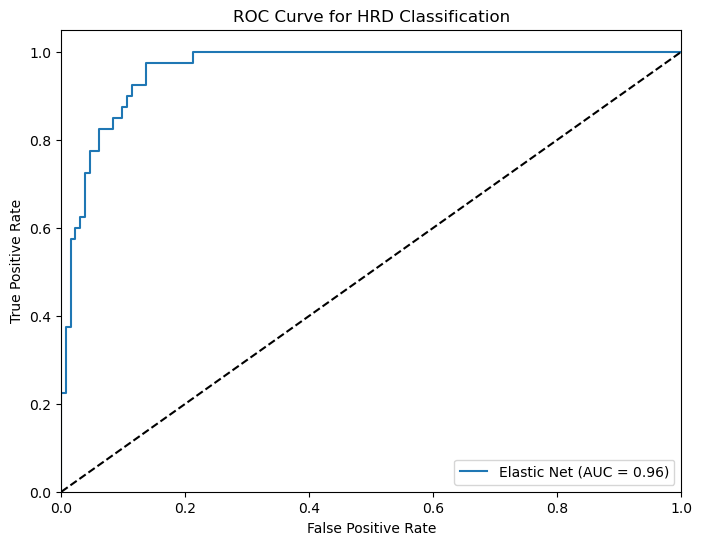


Elastic Net Classification Results:
AUC: 0.963

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       132
           1       0.77      0.82      0.80        40

    accuracy                           0.90       172
   macro avg       0.86      0.87      0.87       172
weighted avg       0.90      0.90      0.90       172


Confusion Matrix:
[[122  10]
 [  7  33]]

Top 500 predictive genes:
['PI3', 'ESYT1', 'H2BC8', 'CNOT6L', 'SPAAR', 'ACSS3', 'R3HDM4', 'NEMP2', 'ADK', 'PYCR1', 'PTDSS2', 'BTC', 'UGT2B15', 'XPNPEP1', 'CDIN1', 'HABP4', 'LDLRAD4', 'ACTL6A', 'NR1D1', 'PRR15', 'ZNF561', 'DHX36', 'YARS1', 'NMB', 'FES', 'NPC1', 'LNP1', 'RBM15B', 'BID', 'TENT5C', 'TRAK1', 'IL17RB', 'VGLL1', 'ABTB2', 'EEF1AKMT1', 'CLSTN1', 'CLEC12A', 'OBP2B', 'IPO5', 'CHI3L2', 'PTEN', 'OTX1', 'LRRC4', 'SDR16C5', 'KIF7', 'BCAS1', 'TAF4', 'KLHDC8A', 'CLEC7A', 'GAR1', 'TLX1', 'IQCG', 'CD276', 'TFAP2C', 'SEPTIN4', 'EIF4EBP1', 'ABCB7', 'CDC37L

In [210]:
results_de, top_genes_de =  main(common_de_genes, softLabel_metadata['HRD_status_base'], n_features=500)


In [211]:
enet_de_model = results_de['Model']

# ENET Linear


Training Elastic Net with Grid Search to predict HRD probabilities:


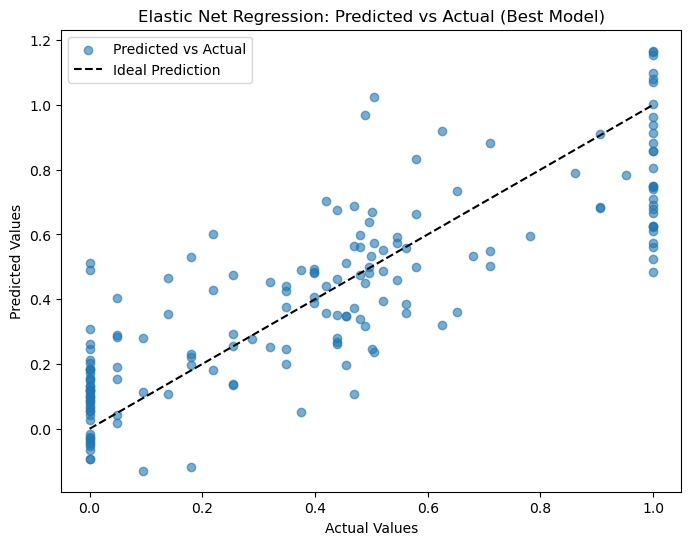

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean Squared Error: 0.039
R^2 Score: 0.691


({'Mean Squared Error': 0.0391127546649974, 'R^2 Score': 0.6910793003697141},
 {'alpha': 0.01, 'l1_ratio': 0.5})

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test
# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

# Main Execution with Hyperparameter Grid Search
def main():
    """
    Main function for preprocessing data, training Elastic Net with grid search, and displaying results.
    """
    print("\nTraining Elastic Net with Grid Search to predict HRD probabilities:")
    
    # Example data preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(common_de_genes, softLabel_metadata['soft prob'], task='regression')
    
    # Define hyperparameter ranges
    alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
    # l1_ratios = [0.1, 0.5, 0.7, 0.9]
    l1_ratios = [0.5]
    
    best_model, best_metrics, best_params = train_evaluate_elastic_net_with_grid_search(
        X_train, X_test, y_train, y_test, alphas, l1_ratios
    )
    
    return best_model, best_metrics, best_params

# Execute Main
LIN_elastic_net_model, elastic_net_metrics, elastic_net_params = main()
elastic_net_metrics, elastic_net_params

# Compare our top genes to Multiscale

In [242]:
reference_sig = pd.read_csv('../data/validation/pre_data/Table S4-Table 1.csv', skiprows=1)

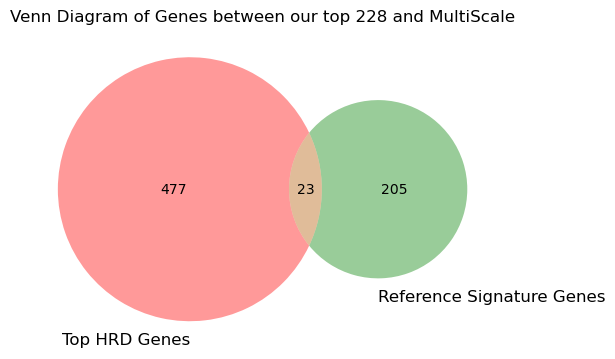

In [243]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assuming 'Gene' columns in both DataFrames
top_genes = set(top_genes_de)
reference_genes = set(reference_sig['Gene'])

# Generate Venn diagram
plt.figure(figsize=(6, 6))
venn = venn2([top_genes, reference_genes], ('Top HRD Genes', 'Reference Signature Genes'))

# Add title
plt.title('Venn Diagram of Genes between our top 228 and MultiScale')
plt.show()


In [244]:
top_genes.intersection(reference_genes)

{'ACAT2',
 'ALDH1B1',
 'ALYREF',
 'ASB7',
 'BET1L',
 'CD109',
 'DCAF7',
 'DHX36',
 'FANCI',
 'FOXK2',
 'FRG1',
 'IPO5',
 'LARP6',
 'MFGE8',
 'MLLT11',
 'POLG',
 'RCCD1',
 'RIC8A',
 'RPTOR',
 'SYK',
 'UNC45A',
 'USP13',
 'ZNF592'}

In [245]:
import decoupler as dc
msigdb = dc.get_resource('MSigDB')
msigdb.drop_duplicates(inplace=True)
gene_list = list(top_genes_de[:228])
ORA_df = dc.get_ora_df(
    df = gene_list,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]

test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
test_pval_filt.tail(10)

plot = sns.scatterplot(
    data=test_pval_filt.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)

KeyboardInterrupt: 

Running ora on df with 228 targets for 33552 sources with 20000 background features.


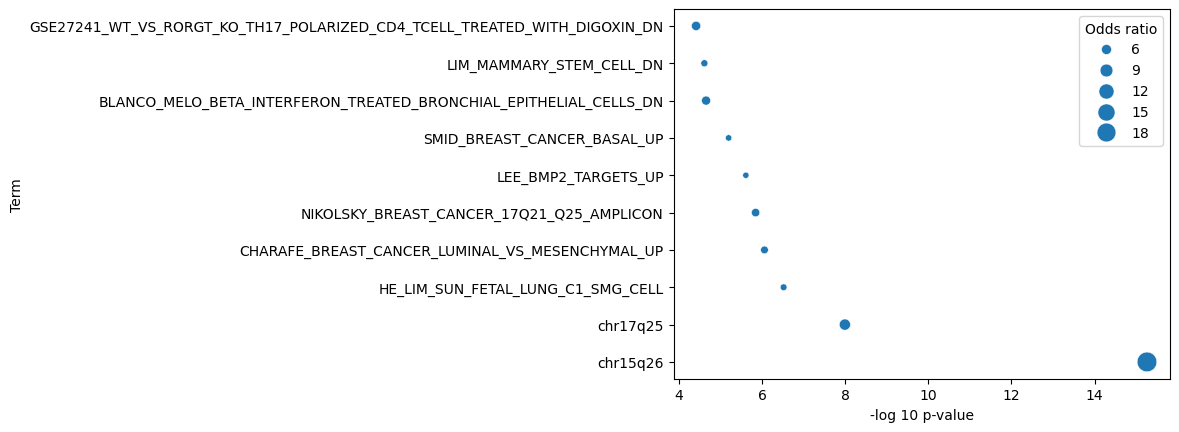

In [217]:
import decoupler as dc
gene_list_Multi = list(reference_sig['Gene'])
ORA_df_2 = dc.get_ora_df(
    df = gene_list_Multi,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

ORA_df_2['-log 10 p-value'] = np.log10(ORA_df_2['p-value'])*-1
test_pval_filt_2 = ORA_df_2[ORA_df_2['p-value'] < 0.05]

test_pval_filt_2 = test_pval_filt_2.sort_values(by=['-log 10 p-value'])
test_pval_filt_2.tail(10)

plot = sns.scatterplot(
    data=test_pval_filt_2.tail(10), x="-log 10 p-value", y="Term",  size="Odds ratio",
    sizes=(20, 200)
)

# ISPY BINARY

In [247]:
import pandas as pd
import numpy as np

In [248]:
ispy2_expr = pd.read_csv('../data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt', sep = '\t')
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)
ispy2_expr_transposed.dropna(inplace=True)

In [249]:
ispy2_expr

671271  856496  111922  965961  549018  337915  751468  446038  \
GeneName                                                                    
1060P11.3   6.708   6.640   6.728   6.675   6.552   6.822   6.204   6.106   
A1BG       10.530  10.380  11.580   9.102   9.592  10.220  10.210  10.230   
A1BG-AS1    7.409   7.666   8.134   7.306   7.860   8.394   7.621   7.782   
A1CF        6.130   5.370   5.782   6.144   6.235   6.551   5.792   5.760   
A2M        10.450   9.582   9.978   9.082   9.447   8.827   9.207   9.656   
...           ...     ...     ...     ...     ...     ...     ...     ...   
ZYG11A      6.088   5.312   5.600   5.536   5.964   5.515   6.270   5.312   
ZYG11B      6.577   7.022   6.732   7.080   6.516   6.773   7.035   7.510   
ZYX        11.100  10.680  11.000  11.000  10.750  10.260  10.200  11.110   
ZZEF1       6.087   6.565   5.960   6.860   6.987   6.412   7.328   6.996   
ZZZ3        8.436   8.340   8.396   8.144   8.021   7.914   8.268   8.134   

           639629  802319  ...  652071  265106  795270  872208  496973  \
GeneName                   ...                                           
1060P11.3   5.893   6.342  ...   7.167   5.817   5.696   5.486   6.273   
A1BG        9.745  12.050  ...  10.350  10.330   9.255  11.480  10.050   
A1BG-AS1    8.245   9.243  ...   7.906   8.073   7.501   8.989   8.227   
A1CF        5.243   5.847  ...   6.568   5.792   6.306   5.458   6.671   
A2M         9.274   8.008  ...   9.412  10.520  10.540   9.466  10.600   
...           ...     ...  ...     ...     ...     ...     ...     ...   
ZYG11A      4.966   5.805  ...   6.032   5.957   4.976   6.758   6.612   
ZYG11B      7.256   6.575  ...   6.894   7.003   6.765   6.857   6.750   
ZYX        10.800  10.950  ...  10.260  10.460  10.650  11.020  10.520   
ZZEF1       6.268   6.468  ...   6.752   6.603   7.022   6.144   7.232   
ZZZ3        8.997   8.046  ...   8.858   8.529   9.328   8.680   8.504   

           194365  989123  524763  384454  979809  
GeneName                                           
1060P11.3   6.128   6.512   6.924   6.555   7.829  
A1BG       11.040  10.060   9.699   9.875  10.190  
A1BG-AS1    9.011   8.447   8.366   8.004   7.807  
A1CF        6.406   6.450   6.320   6.226   7.014  
A2M        10.000  11.230  10.110   8.230  10.630  
...           ...     ...     ...     ...     ...  
ZYG11A      5.928   5.998   5.940   6.015   6.987  
ZYG11B      6.872   7.030   6.588   6.365   7.046  
ZYX        10.460  10.060  11.000  10.130  10.770  
ZZEF1       6.868   6.777   6.805   6.520   6.964  
ZZZ3        8.932   9.020   7.835   8.575   8.330  

[21508 rows x 105 columns]

In [258]:


# Assuming:
# - top_HRD: List of feature names used in training.
# - ispy2_expr_transposed: Validation dataset (DataFrame).
# - enet_de_model: Trained Elastic Net model.

# Step 1: Identify common features
common_features = list(set(common_de_genes) & set(ispy2_expr_transposed.columns))

# Step 2: Subset the validation dataset
validation_subset = ispy2_expr_transposed.loc[:, ispy2_expr_transposed.columns.isin(common_features)]

# Step 3: Handle missing features
# Find features in top_HRD not in validation dataset
missing_features = [feature for feature in common_de_genes.columns if feature not in common_features]

# Add missing features to the validation dataset with default value (e.g., 0)
for feature in missing_features:
    validation_subset[feature] = 0  # Use 0, or the training mean/median if available.
# Step 4: Reorder columns to match training order
validation_subset = validation_subset[common_de_genes.columns]

scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(validation_subset)
# Step 5: Make predictions
predictions = enet_de_model.predict(scaled_data)

# Output predictions
print(predictions)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1387983850.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1387983850.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1387983850.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 0 1 1 1 1 0]


In [259]:
predictions_LIN = LIN_elastic_net_model.predict(scaled_data)

In [260]:
predictions_LIN

array([ 0.31258829,  0.27445033,  0.78249693,  0.61497287,  0.51456652,
        0.19388373,  0.15540792,  0.19587654,  0.19621989,  0.58246003,
        0.32061983,  0.42415746,  0.96817058,  0.43676828,  0.48438194,
        0.27717241,  0.13325366,  0.30661431,  0.63832061,  0.77531104,
        0.37701021,  0.80698918,  0.32653498,  0.47870906,  0.37478528,
        0.63860897,  0.48378415,  0.190263  ,  0.5343912 ,  0.4793005 ,
        0.42408377,  0.32258032,  0.36914025,  0.31574903,  0.77566197,
        0.29207892,  0.37857532,  0.74107511,  0.39946141,  0.30798404,
        0.55090415,  0.34355954,  0.31518776,  0.33428826,  0.32785714,
        0.59833689,  0.42112481,  0.51739355, -0.08053919,  0.79580029,
        0.4603934 ,  0.33435531,  0.41134426, -0.04195399,  0.60502905,
        0.74277872,  0.61262334,  0.71655368,  0.16955945,  0.06994069,
        0.55941791,  0.829676  ,  0.26582007,  0.58231737,  0.46537206,
        0.30047801,  0.57481809,  0.74571954,  0.22371815,  0.00

In [224]:
#predictions

In [261]:
ispy2_response = pd.read_csv('../data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = (
    0  # present in control arm
)

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)

In [262]:
# Find the common indices
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)

# Filter both DataFrames for the common indices, maintaining the order
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]
filtered_ispy_response['predictions_binary'] = predictions
filtered_ispy_response['predictions_linear'] = predictions_LIN

In [263]:
px.box(filtered_ispy_response, y ='predictions_linear', x = 'pCR.status', points = "all", title = f"Distribution of regression scores between patients' complete pathological response")

In [264]:
# two sided welch's t test taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions_linear']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions_linear']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -2.2448, p = 0.0288
Mann-Whitney U test: U = 533.0000, p = 0.0498


In [265]:
from scipy.stats import pearsonr
import numpy as np
import plotly.express as px

# Data for plotting
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions_linear']

# Calculate Pearson R and p-value
r_value, p_value = pearsonr(x, y)

# Create the scatter plot with an adjusted color palette
fig = px.scatter(
    filtered_ispy_response,
    x='PARPi7_sig.',
    y='predictions_linear',
    title=f"Regression scores between patients against PARPi7 sig scores",
    labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
    color='pCR.status',
    trendline="ols",  # Add regression line
    color_continuous_scale='magenta'  # Use a more subtle color palette
)

# Add R value and p-value as annotation
fig.add_annotation(
    x=np.mean(x), 
    y=np.max(y),
    text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value:.2e}",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="white",
    opacity=1.0
)

# Show the plot
fig.show()


In [ ]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', points = "all", title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values", color = 'predictions_binary')

In [ ]:
px.box(filtered_ispy_response, x ='predictions_binary', y = 'PARPi7_sig.', color = 'pCR.status', title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values and pCR", points = "all")

In [232]:
# two sided welch's t test WITHOUT taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 0, 'PARPi7_sig.']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['predictions_binary'] == 1, 'PARPi7_sig.']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -3.8494, p = 0.0004
Mann-Whitney U test: U = 374.0000, p = 0.0012


In [233]:
from scipy.stats import ttest_ind, mannwhitneyu

# Filter the data into two groups based on predictions and pCR.status
group_0 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 0) & (filtered_ispy_response['pCR.status'] == 0),
    'PARPi7_sig.'
]

group_1 = filtered_ispy_response.loc[
    (filtered_ispy_response['predictions_binary'] == 1) & (filtered_ispy_response['pCR.status'] == 1),
    'PARPi7_sig.'
]

# Perform Welch's t-test
t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

# Perform Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -5.0390, p = 0.0001
Mann-Whitney U test: U = 53.0000, p = 0.0002


# CCLE

In [234]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

#genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [235]:
breast_filt = genes_validation_transposed[genes_validation_transposed.index.str.contains('BREAST')]
breast_filt = breast_filt.set_index(breast_filt.index.str.split('_').str[0])
breast_filt.head()

Description  DDX11L1  WASH7P  MIR1302-11  FAM138A  OR4G4P  OR4G11P  OR4F5  \
AU565           32.0  1231.0         3.0      1.0     0.0      0.0    3.0   
BT20            21.0   853.0         2.0      0.0     1.0      3.0    4.0   
BT474            3.0   911.0         5.0      9.0     2.0      3.0    6.0   
BT483           19.0  1306.0         5.0      4.0     7.0      4.0   15.0   
BT549           14.0  1214.0         8.0     11.0     6.0      3.0    7.0   

Description  RP11-34P13.7  CICP27  AL627309.1  ...     MT-ND4  MT-TH  MT-TS2  \
AU565                 4.0   152.0      2582.0  ...  1146916.0    6.0     3.0   
BT20                 10.0   141.0      3214.0  ...  1643737.0    7.0     3.0   
BT474                 3.0    58.0       187.0  ...  1169056.0    8.0     9.0   
BT483                12.0    69.0        33.0  ...  1547088.0   11.0     9.0   
BT549                11.0    42.0        57.0  ...  1039147.0   12.0     4.0   

Description  MT-TL2    MT-ND5    MT-ND6  MT-TE     MT-CYB  MT-TT  MT-TP  
AU565           8.0  389708.0  146916.0   24.0   364079.0    2.0    7.0  
BT20            7.0  558184.0  182410.0   48.0   745031.0    1.0    6.0  
BT474          22.0  522991.0  165302.0   44.0   733933.0   10.0    3.0  
BT483           9.0  798460.0  320052.0   45.0  1245412.0    3.0   35.0  
BT549          16.0  513498.0  160632.0   16.0   644871.0    2.0    6.0  

[5 rows x 56202 columns]

In [236]:
prism = pd.read_excel('../data/validation/PRISM_CCLE.xlsx', skiprows=1)
prism['CellLine'] = prism['CellLine'].replace('-', '', regex=True)

samp_prism = set(list(prism['CellLine']))
samp_val_genes = set(list(breast_filt.index))

common_prism_samples = samp_val_genes.intersection(samp_prism)
breast_filt = breast_filt[breast_filt.index.isin(common_prism_samples)]

In [237]:
import pandas as pd
import numpy as np

# Assuming:
# - top_HRD: List of feature names used in training.
# - ispy2_expr_transposed: Validation dataset (DataFrame).
# - enet_de_model: Trained Elastic Net model.

# Step 1: Identify common features
common_features = list(set(top_genes_de) & set(breast_filt.columns))

# Step 2: Subset the validation dataset
validation_subset = breast_filt.loc[:, breast_filt.columns.isin(common_features)]

# Step 3: Handle missing features
# Find features in top_HRD not in validation dataset
missing_features_2 = [feature for feature in common_de_genes.columns if feature not in common_features]

# Add missing features to the validation dataset with default value (e.g., 0)
for feature in missing_features_2:
    validation_subset[feature] = 0  # Use 0, or the training mean/median if available.
# Step 4: Reorder columns to match training order
validation_subset = validation_subset[common_de_genes.columns]

scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(validation_subset)
# Step 5: Make predictions
predictions_CCLE = enet_de_model.predict(scaled_data)

# Output predictions
print(predictions_CCLE)


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1047870439.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1047870439.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_32934/1047870439.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0]


In [238]:
print(len(missing_features_2))

7614


In [239]:
prism = prism.sort_values(by = 'CellLine')
prism['predictions'] = predictions_CCLE

In [240]:
for col in prism.iloc[:,3:7].columns:
    fig = px.box(prism, x = 'predictions', y = col, color = 'predictions', points = "all", title = f"Distribution of {col} prism scores against model predictions")
    # Filter the data into two groups based on predictions and pCR.status
    group_0 = prism.loc[
        (prism['predictions'] == 0),
        col
    ]

    group_1 = prism.loc[
        (prism['predictions'] == 1),
        col
    ]

    # Perform Welch's t-test
    t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
    print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

    # Perform Mann-Whitney U test
    u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
    print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")
    fig.show()

Welch's t-test: t = -0.9546, p = 0.3504
Mann-Whitney U test: U = 62.0000, p = 0.8214


Welch's t-test: t = 0.6225, p = 0.5463
Mann-Whitney U test: U = 75.0000, p = 0.6512


Welch's t-test: t = 0.4443, p = 0.6640
Mann-Whitney U test: U = 78.0000, p = 0.5336


Welch's t-test: t = nan, p = nan
Mann-Whitney U test: U = nan, p = nan
